In [3]:
! pip install facenet_pytorch mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 70.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 921.0 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch import optim
from torch.optim import lr_scheduler
from facenet_pytorch import InceptionResnetV1
import matplotlib.pyplot as plt
# from google.colab import drive
from PIL import Image
from mtcnn import MTCNN
import torch.nn.functional as F
import cv2
import os

In [5]:
class Face_Dataset_Triplet(Dataset):
    def __init__(self, root_dir, file_root, train=False, test=False):
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        
        if self.train:
            filename = file_root + 'train.txt'
        else:
            filename = file_root + 'test.txt'
            
        self.transform = self.load_transforms()
        with open(filename) as f:
            for line in f:
                line = line.strip().replace('\\', '/').split()
                self.files.append(line[:3])
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        im_names = self.files[idx]
        # Read images using OpenCV
        im1 = cv2.imread(os.path.join(self.root_dir, im_names[0]))
        im2 = cv2.imread(os.path.join(self.root_dir, im_names[1]))
        im3 = cv2.imread(os.path.join(self.root_dir, im_names[2]))
        
        # Convert BGR to RGB
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
        im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image for compatibility with transforms
        im1 = Image.fromarray(im1)
        im2 = Image.fromarray(im2)
        im3 = Image.fromarray(im3)
        
#         # Face alignment using MTCNN
#         im1 = self.align_face(im1)
#         im2 = self.align_face(im2)
#         im3 = self.align_face(im3)
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            im3 = self.transform(im3)
            
        return im1, im2, im3
    
    @staticmethod
    def align_face(im):
        im = np.asarray(im)
        detector = MTCNN()
        results = detector.detect_faces(im)
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = im[y1:y2, x1:x2]
        face_image = Image.fromarray(face)
        return face_image
    
    def load_transforms(self):
        if self.train:
            return transforms.Compose([
                transforms.Resize((160,160)),
                transforms.RandomAffine(15),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                transforms.ToTensor()
            ])
        else:
            return transforms.Compose([
                transforms.Resize((160,160)),
                transforms.ToTensor()
            ])

In [41]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, p=2)
        distance_negative = F.pairwise_distance(anchor, negative, p=2)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [42]:
def train_epoch(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, (anchor, positive, negative) in enumerate(dataloader):
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
        optimizer.zero_grad()
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [43]:
def validate_epoch(dataloader, model, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(dataloader):
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)
            loss = criterion(anchor_out, positive_out, negative_out)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [44]:
def save_model(model, name):
    torch.save(model.state_dict(), f'/kaggle/working/{name}.pth')

In [51]:
# Set hyperparameters
batch_size = 32
lr = 1e-3
n_epochs = 40
log_interval = 50

In [52]:
# Load datasets
face_data_train = Face_Dataset_Triplet(root_dir="/kaggle/input/lfw-funneled/lfw_funneled/lfw_funneled", file_root="/kaggle/input/lfw-funneled/", train=True)
face_data_val = Face_Dataset_Triplet(root_dir="/kaggle/input/lfw-funneled/lfw_funneled/lfw_funneled", file_root="/kaggle/input/lfw-funneled/", test=True)

In [53]:
# Create data loaders
train_dataloader = DataLoader(face_data_train, shuffle=True, num_workers=2, batch_size=batch_size)
test_dataloader = DataLoader(face_data_val, shuffle=True, num_workers=2, batch_size=batch_size)

In [54]:
# Initialize the model
Siamese_network = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("/kaggle/input/pretrained_vggface2/pytorch/default/1/20180402-114759-vggface2.pt")
Siamese_network.load_state_dict(checkpoint)
Siamese_network = Siamese_network.cuda()

In [55]:
# Define loss, optimizer, and scheduler
criterion = TripletLoss()
optimizer = optim.Adam(Siamese_network.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.5, last_epoch=-1)

In [56]:
# Training loop
train_losses = []
val_losses = []
best_loss = np.inf
exp_name = "inception_resnet_V1_triplet"

for epoch in range(n_epochs):
    learning_rate = scheduler.get_last_lr()[0]
    train_loss = train_epoch(train_dataloader, Siamese_network, criterion, optimizer)
    val_loss = validate_epoch(test_dataloader, Siamese_network, criterion)
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        # saving checkpoint 
        save_model(Siamese_network, exp_name)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch Number : {epoch}")
    print("---------------------------------------------------------------")
    print(f"    Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {learning_rate:.6f}")
    print("\n")

Epoch Number : 0
---------------------------------------------------------------
    Train Loss: 0.5133, Val Loss: 0.3891, Learning Rate: 0.001000


Epoch Number : 1
---------------------------------------------------------------
    Train Loss: 0.5526, Val Loss: 0.3080, Learning Rate: 0.001000


Epoch Number : 2
---------------------------------------------------------------
    Train Loss: 0.4393, Val Loss: 0.2722, Learning Rate: 0.001000


Epoch Number : 3
---------------------------------------------------------------
    Train Loss: 0.3826, Val Loss: 0.2695, Learning Rate: 0.001000


Epoch Number : 4
---------------------------------------------------------------
    Train Loss: 0.3042, Val Loss: 0.2208, Learning Rate: 0.000100


Epoch Number : 5
---------------------------------------------------------------
    Train Loss: 0.2850, Val Loss: 0.2094, Learning Rate: 0.000100


Epoch Number : 6
---------------------------------------------------------------
    Train Loss: 0.2715, V

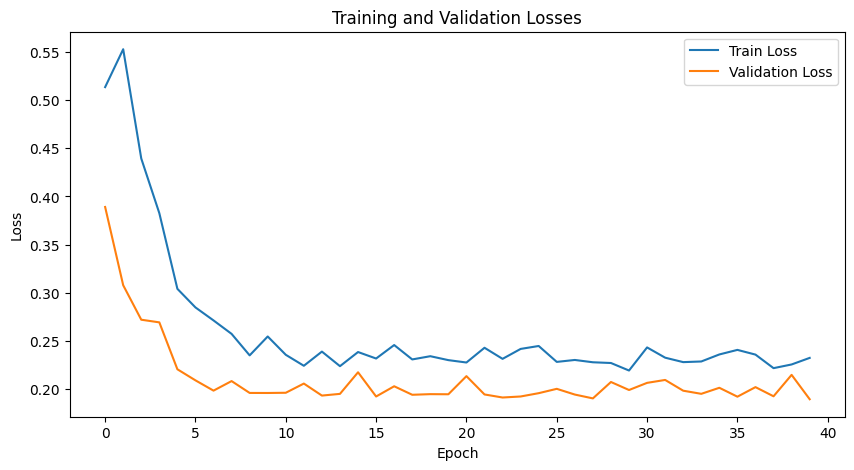

In [57]:
# plot train & validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
# Save the final model
save_model(Siamese_network, f"{exp_name}_final")
print("Training completed. Final model saved.")

Training completed. Final model saved.


****Model Evaluation****

In [5]:
import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
import torch.nn as nn

In [34]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import cv2
from mtcnn.mtcnn import MTCNN

class Face_Dataset(Dataset):
    
    def __init__(self, root_dir='lfw/', filename = '...', test=False):
        
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        
        dataset = set()
        self.transform = self.load_transforms()
        
        with open(filename) as f:
            for line in f:
                line = line.strip().replace('\\', '/').split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        im_names = self.files[idx]
        # Read images using OpenCV
        im1 = cv2.imread(os.path.join(self.root_dir, im_names[0]))
        im2 = cv2.imread(os.path.join(self.root_dir, im_names[1]))
        label = np.array([abs(self.labels[idx])],dtype=np.float32)

        # Convert BGR to RGB
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image for compatibility with transforms
        im1 = Image.fromarray(im1)
        im2 = Image.fromarray(im2)
        
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            
        label = torch.from_numpy(label)
        return im1, im2, label
    
    def align_face(self,im):
        im = np.asarray(im)
        detector = MTCNN()
        results = detector.detect_faces(im)

        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = im[y1:y2, x1:x2]

        face_image = Image.fromarray(face)

        return face_image
    
    def load_transforms(self):
        tet = transforms.Compose([transforms.ToTensor()])
        return tet

In [41]:
face_data_test = Face_Dataset(root_dir="/kaggle/input/lfw-funneled/lfw_funneled/lfw_funneled", filename="/kaggle/input/test-pairs/test_pairs.txt", test=True)
test_dataloader = DataLoader(face_data_test, shuffle=True, num_workers=8, batch_size=8)

Pretrained_model

In [42]:
model = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("/kaggle/input/best-model/pytorch/default/1/inception_resnet_V1_triplet (1).pth")
model.load_state_dict(checkpoint)
model = model.cuda()

In [45]:
labels = []
cosine_similarity = []

for data in test_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  if self.num_workers > max_num_worker_suggest:
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [46]:
thresholds = list(np.arange(0.3, 1.0, 0.01))

cosine_similarity = np.array(cosine_similarity)
f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 

Text(0, 0.5, 'F1 Score')

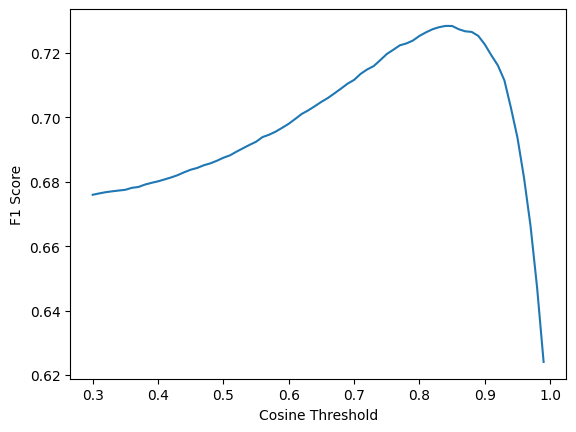

In [47]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Accuracy')

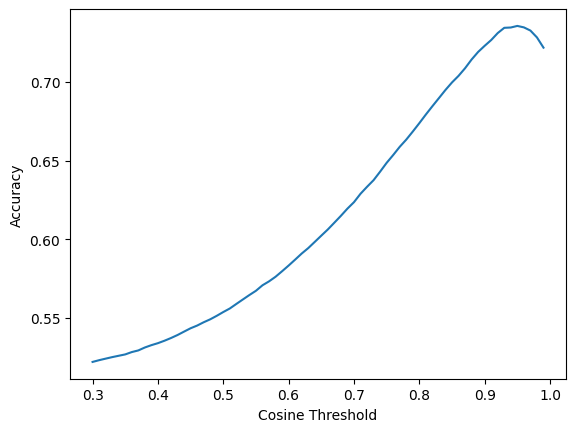

In [48]:
plt.plot(thresholds,acc_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("Accuracy")

In [49]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

max_accuracy = max(acc_scores)

In [50]:
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))


At threshold : 0.84, we get a maximum of f1 score : 0.7284217291179463 


In [51]:
print("Maximum Accuracy : {}".format(round(max_accuracy,4)))

Maximum Accuracy : 0.7355


Base model

In [52]:
model = InceptionResnetV1(pretrained='vggface2')
checkpoint = torch.load("/kaggle/input/pretrained_vggface2/pytorch/default/1/20180402-114759-vggface2.pt")
model.load_state_dict(checkpoint)
model = model.cuda()

In [53]:
labels = []
cosine_similarity = []

for data in test_dataloader:
    
    model.eval()
    with torch.no_grad():
        
        img1 = data[0].cuda()
        img2 = data[1].cuda()
        labels += list(data[2].numpy().flatten().astype(int))
        embedding1 = model(img1)
        embedding2 = model(img2)
        
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cosine_similarity += list(cos(embedding1,embedding2).cpu().numpy())

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  if self.num_workers > max_num_worker_suggest:
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [54]:
thresholds = list(np.arange(0.3, 1.0, 0.01))

cosine_similarity = np.array(cosine_similarity)
f1_scores = [f1_score(labels, cosine_similarity > t) for t in thresholds]
acc_scores = [accuracy_score(labels, cosine_similarity > t) for t in thresholds] 

Text(0, 0.5, 'F1 Score')

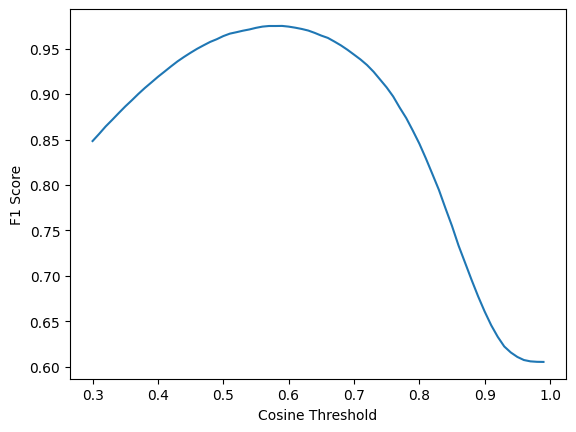

In [55]:
plt.plot(thresholds,f1_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("F1 Score")

Text(0, 0.5, 'Accuracy')

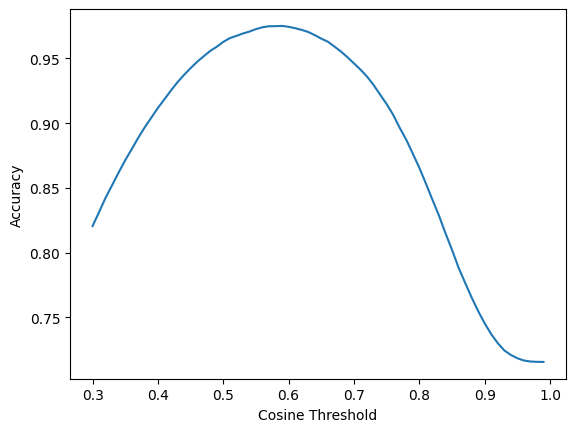

In [56]:
plt.plot(thresholds,acc_scores)
plt.xlabel("Cosine Threshold")
plt.ylabel("Accuracy")

In [57]:
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

max_accuracy = max(acc_scores)

In [58]:
print("At threshold : {}, we get a maximum of f1 score : {} ".format(round(thresholds[max_f1_index],4),max_f1))

At threshold : 0.59, we get a maximum of f1 score : 0.9750763788390416 


In [59]:
print("Maximum Accuracy : {}".format(round(max_accuracy,4)))

Maximum Accuracy : 0.9751


In [3]:
! pip install pendulum

     -------------------------------------- 293.7/293.7 kB 2.6 MB/s eta 0:00:00


In [8]:
import pendulum
print(pendulum.now('asia/ho_chi_minh'))

2024-08-09 02:43:58.497146+07:00
